In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.3 MB/s eta 0:00:00


In [2]:
import os
import torch
import numpy as np
import random
import glob
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from ultralytics import YOLO
from torchvision.ops import nms
import yaml
import pandas as pd
import json

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

# Define paths for Kaggle environment
yolo_dataset_dir = "/kaggle/input/parse-data/yolo_dataset"
yolo_weights_dir = "/kaggle/working/yolo_weights"
yolo_pretrained_weights = "yolov8n.pt"  # Path to pre-downloaded weights

# Create weights directory if it doesn't exist
os.makedirs(yolo_weights_dir, exist_ok=True)

def prepare_dataset(yolo_dataset_dir: str, class_names: dict | None = None) -> str:
    """
    既存の dataset.yaml を優先。無ければ最小構成で作成。
    """
    yolo_dataset_dir = str(yolo_dataset_dir)
    images_train = Path(yolo_dataset_dir) / "images" / "train"
    images_val   = Path(yolo_dataset_dir) / "images" / "val"
    labels_train = Path(yolo_dataset_dir) / "labels" / "train"
    labels_val   = Path(yolo_dataset_dir) / "labels" / "val"

    print("Directory status:")
    print(f"- {images_train} exists: {images_train.exists()}")
    print(f"- {images_val}   exists: {images_val.exists()}")
    print(f"- {labels_train} exists: {labels_train.exists()}")
    print(f"- {labels_val}   exists: {labels_val.exists()}")

    yaml_path = Path(yolo_dataset_dir) / "dataset.yaml"
    if yaml_path.exists():
        print(f"Found dataset.yaml at {yaml_path}")
        # 中身の path/train/val が相対表記かチェックし、相対に修正（YOLOが推奨）
        with open(yaml_path, "r") as f:
            data = yaml.safe_load(f)
        changed = False
        if str(data.get("path", "")) != yolo_dataset_dir:
            data["path"] = yolo_dataset_dir; changed = True
        if data.get("train", "") not in ("images/train", str(images_train)):
            data["train"] = "images/train"; changed = True
        if data.get("val", "") not in ("images/val", str(images_val)):
            data["val"] = "images/val"; changed = True
        if "names" not in data:
            data["names"] = class_names or {0: "aneurysm"}; changed = True
        if changed:
            with open(yaml_path, "w") as f:
                yaml.safe_dump(data, f, sort_keys=False, allow_unicode=True)
            print("dataset.yaml was normalized (path/train/val/names).")
        return str(yaml_path)

    print("dataset.yaml not found. Creating a new one.")
    if class_names is None:
        class_names = {0: "aneurysm"}
    data = {
        "path": yolo_dataset_dir,
        "train": "images/train",
        "val": "images/val",
        "names": class_names,
    }
    with open(yaml_path, "w") as f:
        yaml.safe_dump(data, f, sort_keys=False, allow_unicode=True)
    print(f"Created dataset.yaml at: {yaml_path}")
    return str(yaml_path)


def train_yolo_model(
    yaml_path: str,
    pretrained_weights_path: str,
    project_dir: str,
    run_name: str,
    *,
    epochs: int = 30,
    batch_size: int = 16,
    img_size: int = 640,
    rect: bool = True,         # ← アスペクト比を保つ
    # augmentation knobs (medical想定の控えめ設定)
    mosaic: float = 0.0,       # 医療画像では通常OFFを推奨
    mixup: float = 0.0,
    copy_paste: float = 0.0,
    degrees: float = 5.0,
    translate: float = 0.05,   # 0.0～0.2程度で局所クロップに近い効果
    scale: float = 0.15,       # ズームイン(=実質的なクロップ)も起きる
    shear: float = 0.0,
    perspective: float = 0.0,
    fliplr: float = 0.5,
    flipud: float = 0.0,
    patience: int = 8,
    save_period: int = 5,
    seed: int = 42,
    device: str | int | None = None,
):
    """Ultralytics YOLOv8 の学習。rect=True でアスペクト比維持。"""
    model = YOLO(pretrained_weights_path)
    results = model.train(
        data=yaml_path,
        epochs=epochs,
        batch=batch_size,
        imgsz=img_size,
        project=project_dir,
        name=run_name,
        exist_ok=True,
        device=device,
        seed=seed,
        patience=patience,
        save_period=save_period,
        rect=rect,                      # ← これが“アスペクト比維持”の要
        # built-in augmentation
        mosaic=mosaic,
        mixup=mixup,
        copy_paste=copy_paste,
        degrees=degrees,
        translate=translate,
        scale=scale,
        shear=shear,
        perspective=perspective,
        fliplr=fliplr,
        flipud=flipud,
        workers=2,
        verbose=True,
    )
    run_dir = str(Path(project_dir) / run_name)
    return model, results, run_dir


def _count_split_images_and_boxes(yolo_dataset_dir: str, split: str = "val"):
    """
    画像枚数と GT ボックス数（YOLO txt の行数合計）を数える
    """
    img_paths = list(Path(yolo_dataset_dir, "images", split).rglob("*.png"))
    lbl_dir = Path(yolo_dataset_dir, "labels", split)
    box_count = 0
    for img_p in img_paths:
        rel = img_p.relative_to(Path(yolo_dataset_dir) / "images" / split)
        txt_p = lbl_dir / rel.with_suffix(".txt")
        if txt_p.exists():
            try:
                with open(txt_p, "r") as f:
                    box_count += sum(1 for _ in f if _.strip())
            except Exception:
                pass
    return len(img_paths), box_count


def _safe_scalar(x):
    """
    Ultralytics の metrics から取り出した値を float に丸めるための安全関数
    """
    if x is None:
        return np.nan
    try:
        if hasattr(x, "item"):
            return float(x.item())
        if isinstance(x, (list, tuple, np.ndarray)):
            if len(x) == 0:
                return np.nan
            return float(np.nanmean(x))
        return float(x)
    except Exception:
        return np.nan


def _extract_val_metrics(metrics_obj):
    """
    model.val(...) の戻り値 (metrics) から主なスカラーを抽出
    """
    m = metrics_obj
    out = {
        "mAP50-95": _safe_scalar(getattr(getattr(m, "box", None), "map", None)),
        "mAP50":    _safe_scalar(getattr(getattr(m, "box", None), "map50", None)),
        "precision":_safe_scalar(
            getattr(getattr(m, "box", None), "mp",
                    getattr(getattr(m, "box", None), "p", None))
        ),
        "recall":   _safe_scalar(
            getattr(getattr(m, "box", None), "mr",
                    getattr(getattr(m, "box", None), "r", None))
        ),
    }
    return out


def _read_last_results_row(run_dir: str):
    """
    runs/<name>/results.csv の最終行を dict で返す（無ければ空）
    """
    csv_path = Path(run_dir) / "results.csv"
    if not csv_path.exists():
        return {}
    df = pd.read_csv(csv_path)
    if df.empty:
        return {}
    last = df.iloc[-1].to_dict()
    # 欲しい列だけ薄めに拾う（存在しない場合は自動で無視）
    keys = [
        "val/box_loss", "val/cls_loss", "val/dfl_loss",
        "metrics/mAP50-95(B)", "metrics/mAP50(B)", "metrics/precision(B)", "metrics/recall(B)"
    ]
    return {k: float(last[k]) for k in keys if k in last}


def _summarize_cv(rows, out_dir: str):
    """
    rows: 各 fold の dict を集めたリスト
    - mean / std を計算
    - 画像枚数・GT数での重み付き平均も出力
    """
    df = pd.DataFrame(rows)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    # 平均・標準偏差
    mean = df[num_cols].mean(numeric_only=True)
    std  = df[num_cols].std(numeric_only=True, ddof=1)

    # 重み（画像枚数 / GT数）
    w_img = df["val_images"].to_numpy(dtype=float)
    w_box = df["val_boxes"].to_numpy(dtype=float)
    def wavg(col, w):
        x = df[col].to_numpy(dtype=float)
        mask = ~np.isnan(x) & (w > 0)
        if mask.sum() == 0:
            return np.nan
        return float(np.average(x[mask], weights=w[mask]))

    weighted_img = {col: wavg(col, w_img) for col in num_cols}
    weighted_box = {col: wavg(col, w_box) for col in num_cols}

    # まとめ
    summary = pd.DataFrame({
        "mean": mean,
        "std": std,
        "wavg_by_images": pd.Series(weighted_img),
        "wavg_by_boxes": pd.Series(weighted_box),
    }).sort_index()

    # 保存
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_dir / "cv_folds_raw.csv", index=False)
    summary.to_csv(out_dir / "cv_summary.csv")

    print("\n===== Cross-Validation Summary =====")
    print(summary.loc[["mAP50-95", "mAP50", "precision", "recall",
                       "val/box_loss", "val/cls_loss", "val/dfl_loss"], :].dropna(how="all"))
    print(f"\nSaved CV raw per-fold metrics => {out_dir / 'cv_folds_raw.csv'}")
    print(f"Saved CV summary            => {out_dir / 'cv_summary.csv'}")

    return df, summary


def run_5fold_training_with_cv(
    df: pd.DataFrame,
    base_out_dir: str,
    pretrained_weights_path: str,
    *,
    epochs: int = 30,
    batch_size: int = 16,
    img_size: int = 640,
    folds: int = 5,
    include_unlabeled: bool = True,
    class_names: dict = None,
    rect: bool = True,   # アスペクト比維持
):
    """
    5-fold を回して、foldごとのメトリクス＋CV集計を出力
    """
    if class_names is None:
        class_names = {0: "aneurysm"}

    per_fold_rows = []
    for k in range(folds):
        print(f"\n===== Fold {k} / {folds} =====")
        yolo_dataset_dir = str(Path(base_out_dir) / f"fold{k}")
        # 1) データを fold で振分
        _yaml, _manifest = yolo_distribute_by_fold(
            df, yolo_dataset_dir=yolo_dataset_dir,
            val_fold=k, include_unlabeled=include_unlabeled,
            preserve_subdirs=True, class_names=class_names
        )
        # 2) dataset.yaml
        yaml_path = prepare_dataset(yolo_dataset_dir, class_names=class_names)

        # 3) 学習
        project_dir = str(Path(base_out_dir) / "runs")
        run_name = f"fold{k}"
        model, results, run_dir = train_yolo_model(
            yaml_path=yaml_path,
            pretrained_weights_path=pretrained_weights_path,
            project_dir=project_dir,
            run_name=run_name,
            epochs=epochs, batch_size=batch_size, img_size=img_size,
            rect=rect,
            mosaic=0.5, mixup=0.5, copy_paste=0.0,
            degrees=5.0, translate=0.05, scale=0.15, shear=0.0, perspective=0.0,
            fliplr=0.5, flipud=0.5,
            patience=8, save_period=5, seed=42, device=None,
        )

        # 4) 検証メトリクス
        try:
            metrics = model.val(data=yaml_path, imgsz=img_size, device=None, split="val", max_det=300)
            m = _extract_val_metrics(metrics)
        except Exception as e:
            print(f"[fold{k}] val failed: {e}")
            m = {"mAP50-95": np.nan, "mAP50": np.nan, "precision": np.nan, "recall": np.nan}

        # 5) results.csv の最終行から val 損失などを拾う
        last = _read_last_results_row(run_dir)

        # 6) 画像枚数・GT数
        val_images, val_boxes = _count_split_images_and_boxes(yolo_dataset_dir, split="val")

        row = {
            "fold": k,
            "run_dir": run_dir,
            "dataset_dir": yolo_dataset_dir,
            "val_images": val_images,
            "val_boxes": val_boxes,
            **m,
            **last,   # 例: val/box_loss など
        }
        per_fold_rows.append(row)

        # 7) （任意）可視化
        try:
            predict_on_samples_with_tta(
                model, yolo_dataset_dir=yolo_dataset_dir, split="val",
                num_samples=8, conf=0.25, iou=0.7, img_size=img_size,
                out_png=str(Path(run_dir) / "predictions_grid.png"),
                angles=(0,90,180,270),
                only_one=True
            )
        except Exception as e:
            print(f"[fold{k}] preview failed: {e}")

    # 8) CV 集計
    cv_dir = str(Path(base_out_dir) / "cv_summary")
    df_raw, df_summary = _summarize_cv(per_fold_rows, out_dir=cv_dir)

    return {
        "per_fold": df_raw,
        "summary": df_summary,
        "runs_dir": str(Path(base_out_dir) / "runs"),
        "cv_dir": cv_dir,
    }


def plot_loss_curves(run_dir: str, out_path: str):
    """
    Ultralytics の results.csv から box_loss / cls_loss / dfl_loss / mAP50-95 を描画。
    """
    import pandas as pd
    csv_path = Path(run_dir) / "results.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"{csv_path} not found.")
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10, 7))
    # あれば列を順次描く
    for col in ["train/box_loss", "train/cls_loss", "train/dfl_loss", "val/box_loss", "val/cls_loss", "val/dfl_loss"]:
        if col in df.columns:
            plt.plot(df.index, df[col], label=col)
    for col in ["metrics/mAP50-95(B)","metrics/mAP50(B)","metrics/precision(B)","metrics/recall(B)"]:
        if col in df.columns:
            plt.plot(df.index, df[col], label=col)
    plt.xlabel("epoch")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path)
    plt.close()


# ============ 3) 予測の可視化（GT=YOLO txt を読み込む） ============

def _yolo_txt_to_boxes(txt_path: Path, img_w: int, img_h: int):
    """
    YOLO txt (class cx cy w h) 正規化 → ピクセルの xyxy に変換。
    """
    boxes = []
    if not txt_path.exists():
        return boxes
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5:
                continue
            cls = int(float(parts[0]))
            cx = float(parts[1]) * img_w
            cy = float(parts[2]) * img_h
            w  = float(parts[3]) * img_w
            h  = float(parts[4]) * img_h
            x1 = cx - w / 2
            y1 = cy - h / 2
            x2 = cx + w / 2
            y2 = cy + h / 2
            boxes.append((cls, x1, y1, x2, y2))
    return boxes


def predict_on_samples(
    model,
    yolo_dataset_dir: str,
    split: str = "val",
    num_samples: int = 8,
    conf: float = 0.25,
    iou: float = 0.7,
    img_size: int = 320,
    out_png: str = "/kaggle/working/predictions.png",
):
    """
    split（val/train）からランダムに画像を選び、GT(緑)と予測(赤)を重ね描き。
    サブディレクトリも再帰的に探索。
    """
    split_dir = Path(yolo_dataset_dir) / "images" / split
    if not split_dir.exists():
        alt = Path(yolo_dataset_dir) / "images" / "train"
        print(f"{split_dir} not found. Using {alt}")
        split_dir = alt

    image_paths = [Path(p) for p in glob.glob(str(split_dir / "**" / "*.png"), recursive=True)]
    if len(image_paths) == 0:
        print(f"No images found under {split_dir}")
        return

    samples = random.sample(image_paths, k=min(num_samples, len(image_paths)))

    # 2x2, 3x3 など自動レイアウト
    cols = int(np.ceil(np.sqrt(len(samples))))
    rows = int(np.ceil(len(samples) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.5 * cols, 4.5 * rows))
    axes = np.array(axes).reshape(-1)

    for ax in axes[len(samples):]:
        ax.axis("off")

    for i, img_path in enumerate(samples):
        ax = axes[i]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        ax.imshow(np.array(img))
        ax.set_axis_off()

        # --- GT: labels/<split>/<same_subdir>/<stem>.txt を読む ---
        rel = img_path.relative_to(Path(yolo_dataset_dir) / "images" / split)
        gt_txt = Path(yolo_dataset_dir) / "labels" / split / rel.with_suffix(".txt")
        gt_boxes = _yolo_txt_to_boxes(gt_txt, W, H)
        for cls, x1, y1, x2, y2 in gt_boxes:
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=1.5, edgecolor="g")
            ax.add_patch(rect)

        # --- Prediction ---
        res = model.predict(
            source=str(img_path),
            conf=conf, iou=iou, max_det=1, imgsz=img_size, verbose=False
        )[0]
        if res.boxes is not None and len(res.boxes) > 0:
            xyxy = res.boxes.xyxy.cpu().numpy()
            confs = res.boxes.conf.cpu().numpy()
            clses = res.boxes.cls.cpu().numpy().astype(int)
            for (x1, y1, x2, y2), cf, c in zip(xyxy, confs, clses):
                rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=1.5, edgecolor="r")
                ax.add_patch(rect)
                ax.text(x1, max(y1 - 5, 0), f"{c}:{cf:.2f}", color="r", fontsize=9)

        ax.set_title(f"{split}/{rel.as_posix()}", fontsize=9)

    plt.tight_layout()
    out_png = str(out_png)
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"Saved prediction grid: {out_png}")


def _unrotate_boxes_ccw_xyxy(xyxy, angle, W, H):
    """
    xyxy: (N,4) numpy [x1,y1,x2,y2] （回転後フレーム座標）
    angle: 0/90/180/270 (degree, CCW). We invert this to original W×H.
    戻り値: (N,4) numpy （元フレーム座標）
    変換は点ごとに逆写像してから min/max を取る実装。
    """
    if len(xyxy) == 0:
        return xyxy

    def inv_map_point(xr, yr, ang):
        if ang == 0:
            # x = xr, y = yr
            return xr, yr
        elif ang == 90:
            # 原→回: (xr,yr)=(y, W-x) の逆写像: (x,y)=(W-yr, xr)
            return W - yr, xr
        elif ang == 180:
            # 原→回: (xr,yr)=(W-x, H-y) の逆: (x,y)=(W-xr, H-yr)
            return W - xr, H - yr
        elif ang == 270:
            # 原→回: (xr,yr)=(H-y, x) の逆: (x,y)=(yr, H-xr)
            return yr, H - xr
        else:
            raise ValueError("angle must be 0/90/180/270")

    out = []
    for (x1, y1, x2, y2) in xyxy:
        # 4コーナーを逆回転
        pts = [
            inv_map_point(x1, y1, angle),
            inv_map_point(x2, y1, angle),
            inv_map_point(x1, y2, angle),
            inv_map_point(x2, y2, angle),
        ]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        nx1, ny1, nx2, ny2 = min(xs), min(ys), max(xs), max(ys)
        # 画像境界にクリップ
        nx1 = max(0, min(W - 1, nx1))
        ny1 = max(0, min(H - 1, ny1))
        nx2 = max(0, min(W - 1, nx2))
        ny2 = max(0, min(H - 1, ny2))
        out.append([nx1, ny1, nx2, ny2])
    return np.asarray(out, dtype=np.float32)


# ─────────────────────────────────────────────────────────────
# 回転 TTA 推論（単一画像）
# ─────────────────────────────────────────────────────────────
def predict_with_rotation_tta(
    model,
    image_path,
    angles=(0, 90, 180, 270),  # 使いたい角度（CCW）
    conf=0.25,
    iou=0.7,
    img_size=640,
    max_det=300,
    agnostic_nms=False,        # Trueならクラス無視でNMS
    force_top1=False,          # Trueなら最後に1件に絞る（スコア最大）
):
    """
    画像を角度ごとに回転→推論→boxを元向きに戻して統合→NMS。
    戻り値: dict {"boxes": Nx4, "scores": N, "classes": N}
    """
    img = Image.open(image_path).convert("RGB")
    W, H = img.size

    all_boxes = []
    all_scores = []
    all_classes = []

    for ang in angles:
        # 90°単位のCCW回転（PILの定数で高品質&正確）
        if ang % 360 == 0:
            img_r = img
        elif ang % 360 == 90:
            img_r = img.transpose(Image.ROTATE_90)   # 90°CCW
        elif ang % 360 == 180:
            img_r = img.transpose(Image.ROTATE_180)
        elif ang % 360 == 270:
            img_r = img.transpose(Image.ROTATE_270)  # 270°CCW=90°CW
        else:
            raise ValueError("angles must be multiples of 90")

        # 推論（回転後フレーム）
        res = model.predict(
            source=np.array(img_r),
            conf=conf, iou=iou, imgsz=img_size, max_det=max_det, verbose=False
        )[0]

        if res.boxes is None or len(res.boxes) == 0:
            continue

        xyxy = res.boxes.xyxy.cpu().numpy()
        scores = res.boxes.conf.cpu().numpy()
        clses = res.boxes.cls.cpu().numpy().astype(int) if res.boxes.cls is not None else np.zeros(len(xyxy), int)

        # 予測boxを元向き（W×H）に逆回転
        xyxy_orig = _unrotate_boxes_ccw_xyxy(xyxy, ang % 360, W, H)

        all_boxes.append(xyxy_orig)
        all_scores.append(scores)
        all_classes.append(clses)

    if len(all_boxes) == 0:
        return {"boxes": np.zeros((0,4), dtype=np.float32),
                "scores": np.zeros((0,), dtype=np.float32),
                "classes": np.zeros((0,), dtype=np.int32)}

    boxes = np.vstack(all_boxes)
    scores = np.hstack(all_scores)
    clses = np.hstack(all_classes)

    # ── 結合NMS（クラス別 or クラス無視） ──
    t_boxes = torch.as_tensor(boxes, dtype=torch.float32)
    t_scores = torch.as_tensor(scores, dtype=torch.float32)
    if agnostic_nms:
        keep = nms(t_boxes, t_scores, iou)
    else:
        # クラス別NMS：各クラスごとにNMS→結合
        keep_idx = []
        for c in np.unique(clses):
            idx = np.where(clses == c)[0]
            kept = nms(t_boxes[idx], t_scores[idx], iou)
            keep_idx.append(idx[kept.cpu().numpy()])
        keep = torch.as_tensor(np.concatenate(keep_idx), dtype=torch.long)

    boxes = boxes[keep.numpy()]
    scores = scores[keep.numpy()]
    clses = clses[keep.numpy()]

    # 上位 max_det に制限
    if len(scores) > max_det:
        order = np.argsort(-scores)[:max_det]
        boxes, scores, clses = boxes[order], scores[order], clses[order]

    # 1件だけ欲しい場合
    if force_top1 and len(scores) > 0:
        i = int(np.argmax(scores))
        boxes = boxes[i:i+1]
        scores = scores[i:i+1]
        clses = clses[i:i+1]

    return {"boxes": boxes, "scores": scores, "classes": clses}


def predict_on_samples_with_tta(
    model,
    yolo_dataset_dir: str,
    split: str = "val",
    num_samples: int = 8,
    conf: float = 0.25,
    iou: float = 0.7,
    img_size: int = 640,
    out_png: str = "/kaggle/working/predictions_tta.png",
    angles=(0,90,180,270),
    only_one: bool = False,          # ← 1件だけに絞る
    agnostic_nms: bool = True,
):
    import glob, random, matplotlib.pyplot as plt

    split_dir = Path(yolo_dataset_dir) / "images" / split
    if not split_dir.exists():
        split_dir = Path(yolo_dataset_dir) / "images" / "train"

    image_paths = [Path(p) for p in glob.glob(str(split_dir / "**" / "*.png"), recursive=True)]
    if not image_paths:
        print("no images")
        return

    samples = random.sample(image_paths, k=min(num_samples, len(image_paths)))
    cols = int(np.ceil(np.sqrt(len(samples))))
    rows = int(np.ceil(len(samples) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(4.5*cols, 4.5*rows))
    axes = np.array(axes).reshape(-1)

    for ax in axes[len(samples):]:
        ax.axis("off")

    for i, img_path in enumerate(samples):
        ax = axes[i]
        img = Image.open(img_path).convert("RGB")
        W, H = img.size
        ax.imshow(np.array(img))
        ax.set_axis_off()

        # GT を描画（省略したい場合はこのブロックを消す）
        rel = img_path.relative_to(Path(yolo_dataset_dir) / "images" / split)
        gt_txt = Path(yolo_dataset_dir) / "labels" / split / rel.with_suffix(".txt")
        gt_boxes = _yolo_txt_to_boxes(gt_txt, W, H) if '_yolo_txt_to_boxes' in globals() else []
        for cls, x1, y1, x2, y2 in gt_boxes:
            ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=1.5, edgecolor="g"))

        # 回転TTA予測
        pred = predict_with_rotation_tta(
            model, str(img_path),
            angles=angles, conf=conf, iou=iou, img_size=img_size,
            max_det=1 if only_one else 300,
            agnostic_nms=agnostic_nms,
            force_top1=only_one,
        )

        for (x1,y1,x2,y2), sc, c in zip(pred["boxes"], pred["scores"], pred["classes"]):
            ax.add_patch(Rectangle((x1, y1), x2-x1, y2-y1, fill=False, linewidth=1.5, edgecolor="r"))
            ax.text(x1, max(0, y1-5), f"{int(c)}:{sc:.2f}", color="r", fontsize=9)

        ax.set_title(f"{split}/{rel.as_posix()}", fontsize=9)

    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"Saved TTA preview: {out_png}")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import os
import shutil
from pathlib import Path
import pandas as pd
import yaml

def safe_link_or_copy(src: str, dst: str):
    """容量節約のためハードリンク→失敗時コピー"""
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    if os.path.exists(dst):
        return
    try:
        os.link(src, dst)
    except Exception:
        shutil.copy2(src, dst)

def yolo_distribute_by_fold(
    df: pd.DataFrame,
    yolo_dataset_dir: str,
    val_fold: int,
    include_unlabeled: bool = True,      # ラベル無でも空.txtを作って全保存
    preserve_subdirs: bool = True,       # modality/plane/axis の階層を温存
    class_names: dict = None,            # 例: {0: "aneurysm"}
):
    """
    DataFrame の 'fold' で分割:
      - train: fold != val_fold
      - val:   fold == val_fold
    画像は df['filepath']、ラベルは同階層の 'labels_yolo' に .txt がある前提で、
    /images/ → /labels_yolo/ に置換し拡張子 .png→.txt として推定。
    """
    req_cols = ["filepath", "filename", "fold"]
    for c in req_cols:
        if c not in df.columns:
            raise ValueError(f"DataFrame に必須列 '{c}' がありません。")

    # 出力先作成
    for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
        os.makedirs(os.path.join(yolo_dataset_dir, sub), exist_ok=True)

    stats = { "train": {"img":0, "lbl":0, "skipped":0},
              "val":   {"img":0, "lbl":0, "skipped":0} }
    manifests = []

    for _, row in df.iterrows():
        split = "val" if int(row["fold"]) == int(val_fold) else "train"

        img_src = str(row["filepath"])
        # ラベルパス推定: /images/ → /labels_yolo/、拡張子 .png → .txt
        if "/images/" in img_src:
            lbl_src = img_src.replace("/images/", "/labels_yolo/")
        else:
            # 念のため最後の 'images' を置換
            parts = img_src.split("/")
            try:
                last_idx = len(parts) - 1 - parts[::-1].index("images")
                parts[last_idx] = "labels_yolo"
                lbl_src = "/".join(parts)
            except ValueError:
                # 見つからない場合は同ディレクトリ扱い
                lbl_src = str(Path(img_src).with_suffix(".txt"))
        if lbl_src.endswith(".png"):
            lbl_src = lbl_src[:-4] + ".txt"
        else:
            lbl_src = str(Path(lbl_src).with_suffix(".txt"))

        # 出力先の相対サブパス
        if preserve_subdirs and all(k in df.columns for k in ["modality","plane","axis"]):
            subdir = f"{row['modality']}/{row['plane']}/{row['axis']}"
        else:
            subdir = ""

        # 出力フルパス
        dst_img = os.path.join(yolo_dataset_dir, "images", split, subdir, row["filename"])
        dst_lbl = os.path.join(
            yolo_dataset_dir, "labels", split, subdir, Path(row["filename"]).with_suffix(".txt").name
        )

        # 存在チェック
        img_ok = os.path.exists(img_src)
        lbl_ok = os.path.exists(lbl_src)

        if not img_ok:
            stats[split]["skipped"] += 1
            continue

        # 画像の配置
        safe_link_or_copy(img_src, dst_img)
        stats[split]["img"] += 1

        # ラベルの配置（無ければ include_unlabeled に応じて空ファイル）
        if lbl_ok:
            safe_link_or_copy(lbl_src, dst_lbl)
            stats[split]["lbl"] += 1
        else:
            if include_unlabeled:
                os.makedirs(os.path.dirname(dst_lbl), exist_ok=True)
                open(dst_lbl, "a").close()
                # 空ラベルは 'lbl' にカウントしない
            else:
                stats[split]["skipped"] += 1
                # 画像だけ残すのは避けたい場合は、必要に応じて画像削除も検討

        manifests.append({
            "split": split,
            "filepath": img_src,
            "labelpath": lbl_src if lbl_ok else None,
            "dst_img": dst_img,
            "dst_lbl": dst_lbl,
            "modality": row.get("modality"),
            "plane": row.get("plane"),
            "axis": row.get("axis"),
            "SeriesInstanceUID": row.get("SeriesInstanceUID"),
            "fold": row["fold"],
        })

    # dataset.yaml
    if class_names is None:
        class_names = {0: "aneurysm"}  # 必要に応じて変更
    dataset_yaml = {
        "path": yolo_dataset_dir,
        "train": "images/train",
        "val": "images/val",
        "names": class_names,
    }
    yaml_path = os.path.join(yolo_dataset_dir, "dataset.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(dataset_yaml, f, sort_keys=False, allow_unicode=True)

    # manifest 保存
    manifest_csv = os.path.join(yolo_dataset_dir, "manifest.csv")
    pd.DataFrame(manifests).to_csv(manifest_csv, index=False)

    # サマリ
    print(f"[Split summary]  base: {yolo_dataset_dir}  (val_fold={val_fold})")
    for split in ["train","val"]:
        print(f"  {split:5s} imgs: {stats[split]['img']:5d} | lbls: {stats[split]['lbl']:5d} | skipped: {stats[split]['skipped']:5d}")
    print(f"YAML:     {yaml_path}")
    print(f"Manifest: {manifest_csv}")

    return yaml_path, manifest_csv


In [4]:
def _read_yolo_txt(txt_path: Path):
    boxes = []
    if not txt_path.exists():
        return boxes
    for line in txt_path.read_text().splitlines():
        line = line.strip()
        if not line:
            continue
        parts = line.split()
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        cx, cy, w, h = map(float, parts[1:5])
        rest = parts[5:]
        boxes.append((cls, cx, cy, w, h, rest))
    return boxes

def _write_yolo_txt(txt_path: Path, boxes):
    lines = []
    for cls, cx, cy, w, h, rest in boxes:
        tail = (" " + " ".join(rest)) if rest else ""
        lines.append(f"{cls} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}{tail}")
    txt_path.parent.mkdir(parents=True, exist_ok=True)
    txt_path.write_text("\n".join(lines) + ("\n" if lines else ""))

def _rot90_ccw_yolo(cls_cxcywh_list, angle_ccw: int):
    """YOLO正規化(cx,cy,w,h)を 0/90/180/270° CCWで回転"""
    out = []
    for cls, cx, cy, w, h, rest in cls_cxcywh_list:
        if angle_ccw == 0:
            nx, ny, nw, nh = cx, cy, w, h
        elif angle_ccw == 90:
            nx, ny, nw, nh = cy, 1.0 - cx, h, w
        elif angle_ccw == 180:
            nx, ny, nw, nh = 1.0 - cx, 1.0 - cy, w, h
        elif angle_ccw == 270:
            nx, ny, nw, nh = 1.0 - cy, cx, h, w
        else:
            raise ValueError("angle must be 0/90/180/270")
        nx = min(max(nx, 0.0), 1.0); ny = min(max(ny, 0.0), 1.0)
        nw = min(max(nw, 0.0), 1.0); nh = min(max(nh, 0.0), 1.0)
        out.append((cls, nx, ny, nw, nh, rest))
    return out

def augment_train_with_right_angle_rotations(yolo_dataset_dir: str,
                                             angles=(90, 180, 270),
                                             suffix_map={90:"r90",180:"r180",270:"r270"},
                                             overwrite=False):
    """
    images/train, labels/train の全サンプルを指定角度で回転コピーし、対応するYOLOラベルも回転。
    """
    base = Path(yolo_dataset_dir)
    img_root = base / "images" / "train"
    lbl_root = base / "labels" / "train"
    assert img_root.exists(), f"{img_root} not found"

    img_paths = list(img_root.rglob("*.png")) + list(img_root.rglob("*.jpg")) + list(img_root.rglob("*.jpeg"))
    print(f"[augment] train images: {len(img_paths)} | angles={angles}")

    for img_path in img_paths:
        rel = img_path.relative_to(img_root)
        txt_path = lbl_root / rel.with_suffix(".txt")
        boxes = _read_yolo_txt(txt_path)
        img = Image.open(img_path).convert("RGB")

        for ang in angles:
            tag = suffix_map.get(ang, f"r{ang}")
            new_name = img_path.stem + f"_{tag}" + img_path.suffix
            out_img = img_root / rel.parent / new_name
            out_txt = lbl_root / rel.parent / (Path(new_name).with_suffix(".txt").name)

            if out_img.exists() and not overwrite:
                continue

            if ang == 0: img_r = img
            elif ang == 90:  img_r = img.transpose(Image.ROTATE_90)
            elif ang == 180: img_r = img.transpose(Image.ROTATE_180)
            elif ang == 270: img_r = img.transpose(Image.ROTATE_270)
            else: raise ValueError

            out_img.parent.mkdir(parents=True, exist_ok=True)
            img_r.save(out_img)

            if boxes:
                boxes_r = _rot90_ccw_yolo(boxes, ang)
                _write_yolo_txt(out_txt, boxes_r)
            else:
                out_txt.parent.mkdir(parents=True, exist_ok=True)
                if not out_txt.exists():
                    out_txt.write_text("")

    print("[augment] done.")


def run_5fold_training_with_rot90_cv(
    df: pd.DataFrame,
    base_out_dir: str,
    pretrained_weights_path: str,
    *,
    folds: int = 5,
    angles=(90,180,270),
    include_unlabeled: bool = True,
    class_names: dict | None = None,
    epochs: int = 30,
    batch_size: int = 16,
    img_size: int = 640,
    rect: bool = True,                 # アスペクト比維持
    translate: float = 0.05,           # 軽い平行移動でクロップ近似
    scale: float = 0.15,               # 軽いズームでクロップ近似
):
    if class_names is None:
        class_names = {0: "aneurysm"}

    per_fold_rows = []
    for k in range(folds):
        print(f"\n===== Fold {k}/{folds} =====")
        yolo_dataset_dir = str(Path(base_out_dir) / f"fold{k}")

        # 1) fold で分割（val=k, train≠k）
        _yaml, _manifest = yolo_distribute_by_fold(
            df,
            yolo_dataset_dir=yolo_dataset_dir,
            val_fold=k,
            include_unlabeled=include_unlabeled,
            preserve_subdirs=True,
            class_names=class_names,
        )

        # 2) train のみ 90/180/270 増強を追加生成
        augment_train_with_right_angle_rotations(yolo_dataset_dir, angles=angles)

        # 3) dataset.yaml 準備
        yaml_path = prepare_dataset(yolo_dataset_dir, class_names=class_names)

        # 4) 学習（rect=True、mosaic/mixupは医用想定でOFF）
        project_dir = str(Path(base_out_dir) / "runs")
        run_name = f"fold{k}"
        model, results, run_dir = train_yolo_model(
            yaml_path=yaml_path,
            pretrained_weights_path=pretrained_weights_path,
            project_dir=project_dir,
            run_name=run_name,
            epochs=epochs, batch_size=batch_size, img_size=img_size,
            rect=rect,
            mosaic=0.0, mixup=0.0, copy_paste=0.0,
            degrees=5.0, translate=translate, scale=scale, shear=0.0, perspective=0.0,
            fliplr=0.5, flipud=0.0,
            patience=8, save_period=5, seed=42, device=None,
        )

        # 5) 検証メトリクス取得
        try:
            metrics = model.val(data=yaml_path, imgsz=img_size, device=None, split="val")
            m = _extract_val_metrics(metrics)
        except Exception as e:
            print(f"[fold{k}] val failed: {e}")
            m = {"mAP50-95": np.nan, "mAP50": np.nan, "precision": np.nan, "recall": np.nan}

        # 6) results.csv 最終行（val損失など）
        last = _read_last_results_row(run_dir)

        # 7) val 枚数 / GT数
        val_images, val_boxes = _count_split_images_and_boxes(yolo_dataset_dir, split="val")

        per_fold_rows.append({
            "fold": k, "run_dir": run_dir, "dataset_dir": yolo_dataset_dir,
            "val_images": val_images, "val_boxes": val_boxes,
            **m, **last,
        })

        # 8) サンプル可視化（任意）
        try:
            # predict_on_samples(
            #     model, yolo_dataset_dir=yolo_dataset_dir, split="val",
            #     num_samples=8, conf=0.25, iou=0.7, img_size=img_size,
            #     out_png=str(Path(run_dir) / "predictions_grid.png"),
            # )
            predict_on_samples_with_tta(
                model, yolo_dataset_dir=yolo_dataset_dir, split="val",
                num_samples=8, conf=0.25, iou=0.7, img_size=img_size,
                out_png=str(Path(run_dir) / "predictions_grid.png"),
                angles=(0,90,180,270),
                only_one=True
            )
        except Exception as e:
            print(f"[fold{k}] preview failed: {e}")

    # 9) CV集計
    cv_dir = str(Path(base_out_dir) / "cv_summary")
    df_raw, df_summary = _summarize_cv(per_fold_rows, out_dir=cv_dir)
    return {"per_fold": df_raw, "summary": df_summary, "runs_dir": str(Path(base_out_dir) / "runs"), "cv_dir": cv_dir}

In [5]:
def parse_path(p):
    p = Path(p)
    # .../MRA/AXIAL/axis2/images/<file> という末尾構造を前提
    modality = p.parts[-5]   # MRA
    plane    = p.parts[-4]   # AXIAL
    axis     = p.parts[-3]   # axis2
    filename = p.name
    return pd.Series([modality, plane, axis, filename],
                     index=["modality", "plane", "axis", "filename"])

In [6]:
df_comp = pd.read_csv('/kaggle/input/rsna2025-extra/train_add_metadata_v3.csv')
df_comp

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

SeriesInstanceUID  PatientAge  \
0     1.2.826.0.1.3680043.8.498.10004044428023505108...          64   
1     1.2.826.0.1.3680043.8.498.10004684224894397679...          76   
2     1.2.826.0.1.3680043.8.498.10005158603912009425...          58   
3     1.2.826.0.1.3680043.8.498.10009383108068795488...          71   
4     1.2.826.0.1.3680043.8.498.10012790035410518400...          48   
...                                                 ...         ...   
4343  1.2.826.0.1.3680043.8.498.99915610493694667606...          62   
4344  1.2.826.0.1.3680043.8.498.99920680741054836990...          76   
4345  1.2.826.0.1.3680043.8.498.99953513260518059135...          44   
4346  1.2.826.0.1.3680043.8.498.99982144859397209076...          58   
4347  1.2.826.0.1.3680043.8.498.99985209798463601651...          65   

     PatientSex    Modality  Left Infraclinoid Internal Carotid Artery  \
0        Female         MRA                                          0   
1        Female         MRA                                          0   
2          Male         CTA                                          0   
3          Male         MRA                                          0   
4        Female         MRA                                          0   
...         ...         ...                                        ...   
4343     Female  MRI T1post                                          0   
4344     Female         MRA                                          0   
4345     Female         CTA                                          0   
4346     Female      MRI T2                                          0   
4347     Female         CTA                                          0   

      Right Infraclinoid Internal Carotid Artery  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
4343                                           0   
4344                                           0   
4345                                           0   
4346                                           0   
4347                                           0   

      Left Supraclinoid Internal Carotid Artery  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
4343                                          0   
4344                                          0   
4345                                          0   
4346                                          0   
4347                                          0   

      Right Supraclinoid Internal Carotid Artery  Left Middle Cerebral Artery  \
0                                              0                            0   
1                                              0                            0   
2                                              0                            0   
3                                              0                            0   
4                                              0                            0   
...                                          ...                          ...   
4343                                           0                            0   
4344                                           0                            0   
4345                                           0                            0   
4346                                           0                            0   
4347                                           0                            1   

      Right Middle Cerebral Artery  ...  SliceThickness  SpacingBetweenSlices  \
0   

In [7]:
paths = list(Path('/kaggle/input/rsna-bbox-annotation-fix/results/detetion_annotation').glob('*/*/*/images/*'))
df = pd.DataFrame({'filepath': paths})

In [8]:
df[["modality","plane","axis","filename"]] = df['filepath'].apply(parse_path)
df['SeriesInstanceUID'] = df['filename'].apply(lambda x: x[:-4])
df

filepath    modality    plane  \
0    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
1    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
2    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
3    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
4    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
..                                                 ...         ...      ...   
524  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post    AXIAL   
525  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post    AXIAL   
526  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post  CORONAL   
527  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post  CORONAL   
528  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post  CORONAL   

      axis                                           filename  \
0    axis2  1.2.826.0.1.3680043.8.498.56479623144539472445...   
1    axis2  1.2.826.0.1.3680043.8.498.28722601444191262075...   
2    axis2  1.2.826.0.1.3680043.8.498.68709340002397343932...   
3    axis2  1.2.826.0.1.3680043.8.498.69568746915553014138...   
4    axis2  1.2.826.0.1.3680043.8.498.19915189891686122627...   
..     ...                                                ...   
524  axis1  1.2.826.0.1.3680043.8.498.12427930128533148989...   
525  axis1  1.2.826.0.1.3680043.8.498.12180351938456969219...   
526  axis2  1.2.826.0.1.3680043.8.498.84908441442551598157...   
527  axis0  1.2.826.0.1.3680043.8.498.84908441442551598157...   
528  axis1  1.2.826.0.1.3680043.8.498.84908441442551598157...   

                                     SeriesInstanceUID  
0    1.2.826.0.1.3680043.8.498.56479623144539472445...  
1    1.2.826.0.1.3680043.8.498.28722601444191262075...  
2    1.2.826.0.1.3680043.8.498.68709340002397343932...  
3    1.2.826.0.1.3680043.8.498.69568746915553014138...  
4    1.2.826.0.1.3680043.8.498.19915189891686122627...  
..                                                 ...  
524  1.2.826.0.1.3680043.8.498.12427930128533148989...  
525  1.2.826.0.1.3680043.8.498.12180351938456969219...  
526  1.2.826.0.1.3680043.8.498.84908441442551598157...  
527  1.2.826.0.1.3680043.8.498.84908441442551598157...  
528  1.2.826.0.1.3680043.8.498.84908441442551598157...  

[529 rows x 6 columns]

In [9]:
df = df.merge(
    df_comp[["SeriesInstanceUID", "fold"]].drop_duplicates("SeriesInstanceUID"),
    on="SeriesInstanceUID",
    how="left",
    validate="m:1",          # 1つのSeriesInstanceUIDにfoldが1件であることを保証
)

In [10]:
# Axialを削除　ラベルエラーがあるので目視で確認済み
drop_patterns = [('AXIAL', 'axis2'),
                ('SAGITTAL', 'axis2'),
                ('CORONAL', 'axis0')
               ]
for pattern in drop_patterns:
    plane, axis = pattern
    df = df[~((df['plane']==plane)&(df['axis']==axis))]
df = df.reset_index(drop=True)
df

filepath    modality    plane  \
0    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
1    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
2    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
3    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
4    /kaggle/input/rsna-bbox-annotation-fix/results...         MRA    AXIAL   
..                                                 ...         ...      ...   
347  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post    AXIAL   
348  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post    AXIAL   
349  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post    AXIAL   
350  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post  CORONAL   
351  /kaggle/input/rsna-bbox-annotation-fix/results...  MRI T1post  CORONAL   

      axis                                           filename  \
0    axis0  1.2.826.0.1.3680043.8.498.56479623144539472445...   
1    axis0  1.2.826.0.1.3680043.8.498.28722601444191262075...   
2    axis0  1.2.826.0.1.3680043.8.498.69568746915553014138...   
3    axis0  1.2.826.0.1.3680043.8.498.19915189891686122627...   
4    axis0  1.2.826.0.1.3680043.8.498.10410600166004340343...   
..     ...                                                ...   
347  axis1  1.2.826.0.1.3680043.8.498.11163718560814217911...   
348  axis1  1.2.826.0.1.3680043.8.498.12427930128533148989...   
349  axis1  1.2.826.0.1.3680043.8.498.12180351938456969219...   
350  axis2  1.2.826.0.1.3680043.8.498.84908441442551598157...   
351  axis1  1.2.826.0.1.3680043.8.498.84908441442551598157...   

                                     SeriesInstanceUID  fold  
0    1.2.826.0.1.3680043.8.498.56479623144539472445...     0  
1    1.2.826.0.1.3680043.8.498.28722601444191262075...     4  
2    1.2.826.0.1.3680043.8.498.69568746915553014138...     3  
3    1.2.826.0.1.3680043.8.498.19915189891686122627...     2  
4    1.2.826.0.1.3680043.8.498.10410600166004340343...     3  
..                                                 ...   ...  
347  1.2.826.0.1.3680043.8.498.11163718560814217911...     4  
348  1.2.826.0.1.3680043.8.498.12427930128533148989...     4  
349  1.2.826.0.1.3680043.8.498.12180351938456969219...     3  
350  1.2.826.0.1.3680043.8.498.84908441442551598157...     3  
351  1.2.826.0.1.3680043.8.498.84908441442551598157...     3  

[352 rows x 7 columns]


===== Fold 0/5 =====
[Split summary]  base: /kaggle/working/yolo_cv_rot90/fold0  (val_fold=0)
  train imgs:   274 | lbls:   274 | skipped:     0
  val   imgs:    78 | lbls:    78 | skipped:     0
YAML:     /kaggle/working/yolo_cv_rot90/fold0/dataset.yaml
Manifest: /kaggle/working/yolo_cv_rot90/fold0/manifest.csv
[augment] train images: 274 | angles=(90, 180, 270)
[augment] done.
Directory status:
- /kaggle/working/yolo_cv_rot90/fold0/images/train exists: True
- /kaggle/working/yolo_cv_rot90/fold0/images/val   exists: True
- /kaggle/working/yolo_cv_rot90/fold0/labels/train exists: True
- /kaggle/working/yolo_cv_rot90/fold0/labels/val   exists: True
Found dataset.yaml at /kaggle/working/yolo_cv_rot90/fold0/dataset.yaml
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, 

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         78         78      0.916      0.885      0.881      0.532
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold0
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 541.4±151.7 MB/s, size: 17.2 KB)
val: Scanning /kaggle/working/yolo_cv_rot90/fold0/labels/val/CTA/AXIAL/axis0.cache... 78 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 78/78 148504.6it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 4.9it/s 1.0s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         78         78      0.929      0.897      0.886       0.53
Speed: 1.6ms preprocess, 8.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold0


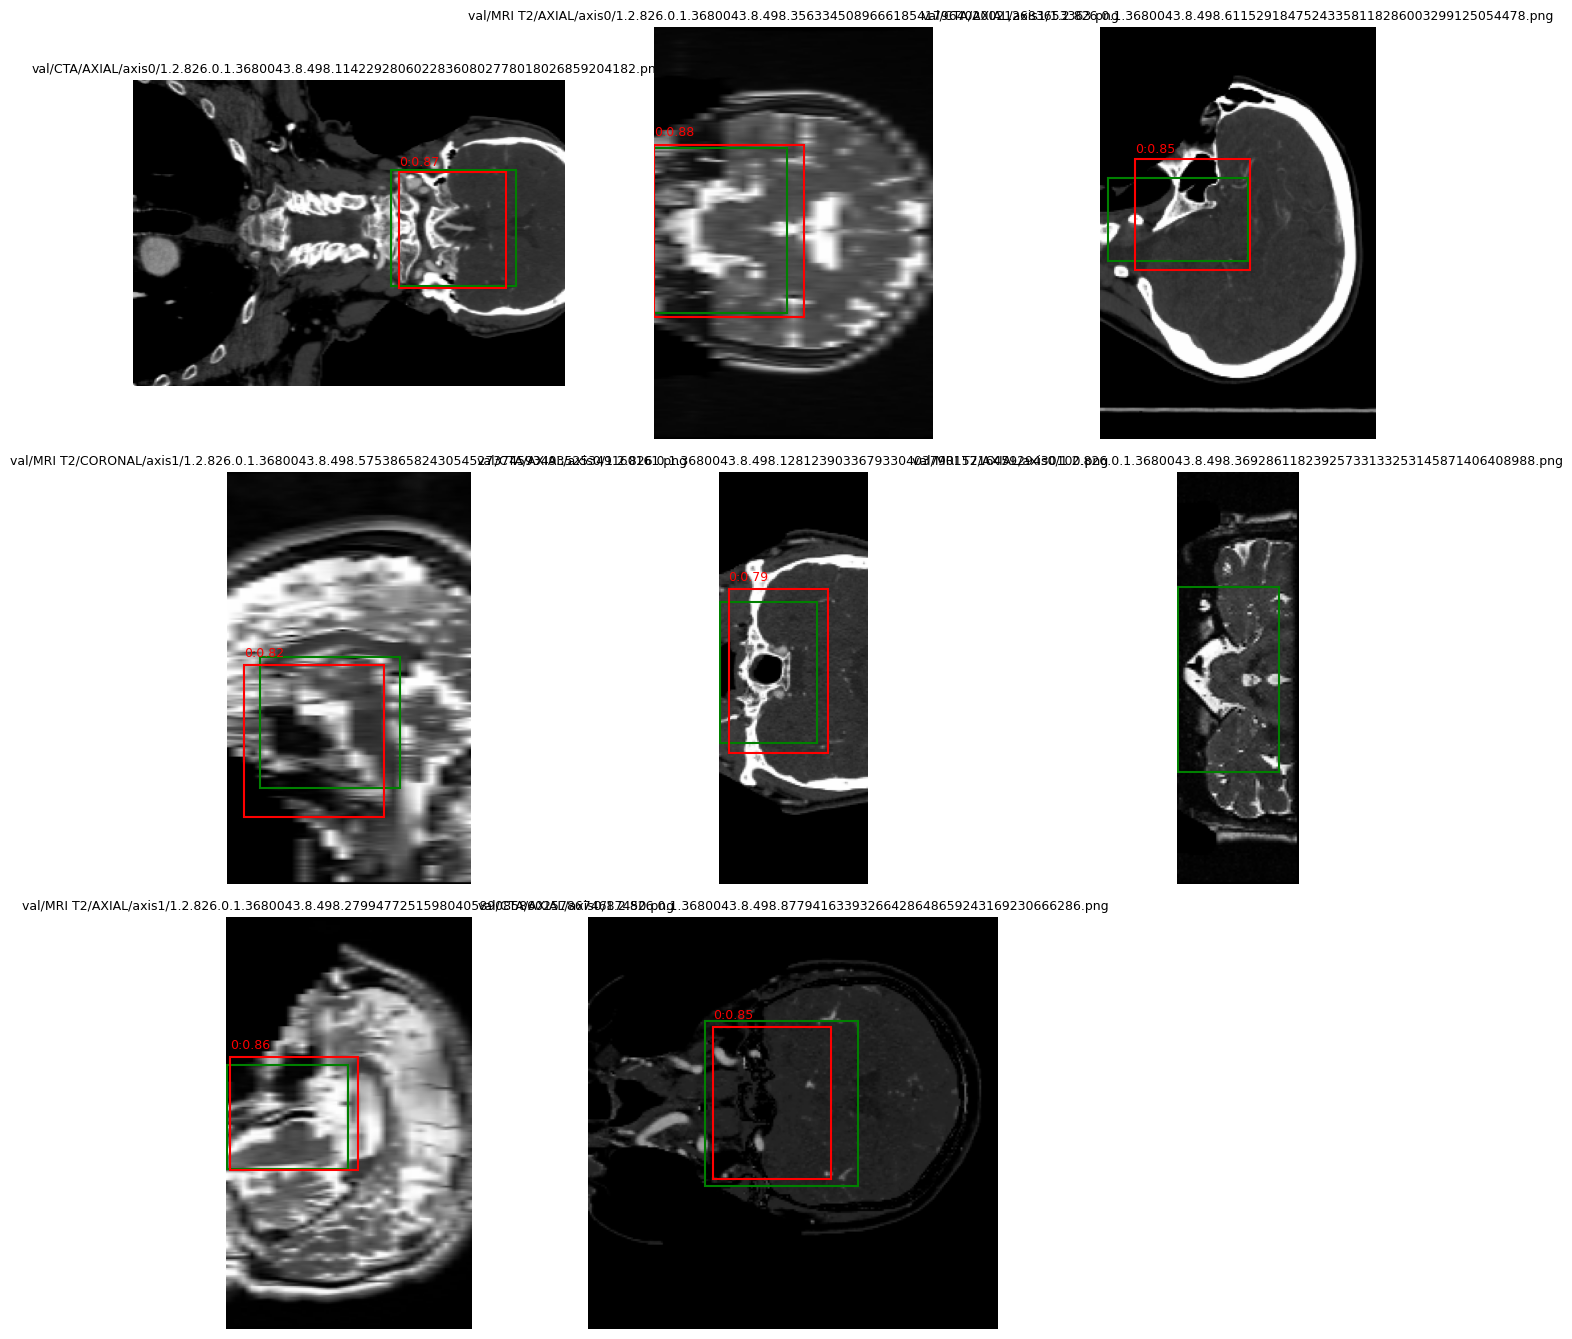

Saved TTA preview: /kaggle/working/yolo_cv_rot90/runs/fold0/predictions_grid.png

===== Fold 1/5 =====
[Split summary]  base: /kaggle/working/yolo_cv_rot90/fold1  (val_fold=1)
  train imgs:   276 | lbls:   276 | skipped:     0
  val   imgs:    76 | lbls:    76 | skipped:     0
YAML:     /kaggle/working/yolo_cv_rot90/fold1/dataset.yaml
Manifest: /kaggle/working/yolo_cv_rot90/fold1/manifest.csv
[augment] train images: 276 | angles=(90, 180, 270)
[augment] done.
Directory status:
- /kaggle/working/yolo_cv_rot90/fold1/images/train exists: True
- /kaggle/working/yolo_cv_rot90/fold1/images/val   exists: True
- /kaggle/working/yolo_cv_rot90/fold1/labels/train exists: True
- /kaggle/working/yolo_cv_rot90/fold1/labels/val   exists: True
Found dataset.yaml at /kaggle/working/yolo_cv_rot90/fold1/dataset.yaml
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, bo

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         76         76      0.937      0.971      0.966       0.61
Speed: 0.1ms preprocess, 3.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold1
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 466.0±86.9 MB/s, size: 13.1 KB)
val: Scanning /kaggle/working/yolo_cv_rot90/fold1/labels/val/CTA/AXIAL/axis0.cache... 76 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 76/76 110223.8it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 4.8it/s 1.0s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         76         76      0.937      0.971      0.966      0.603
Speed: 1.6ms preprocess, 5.5ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold1


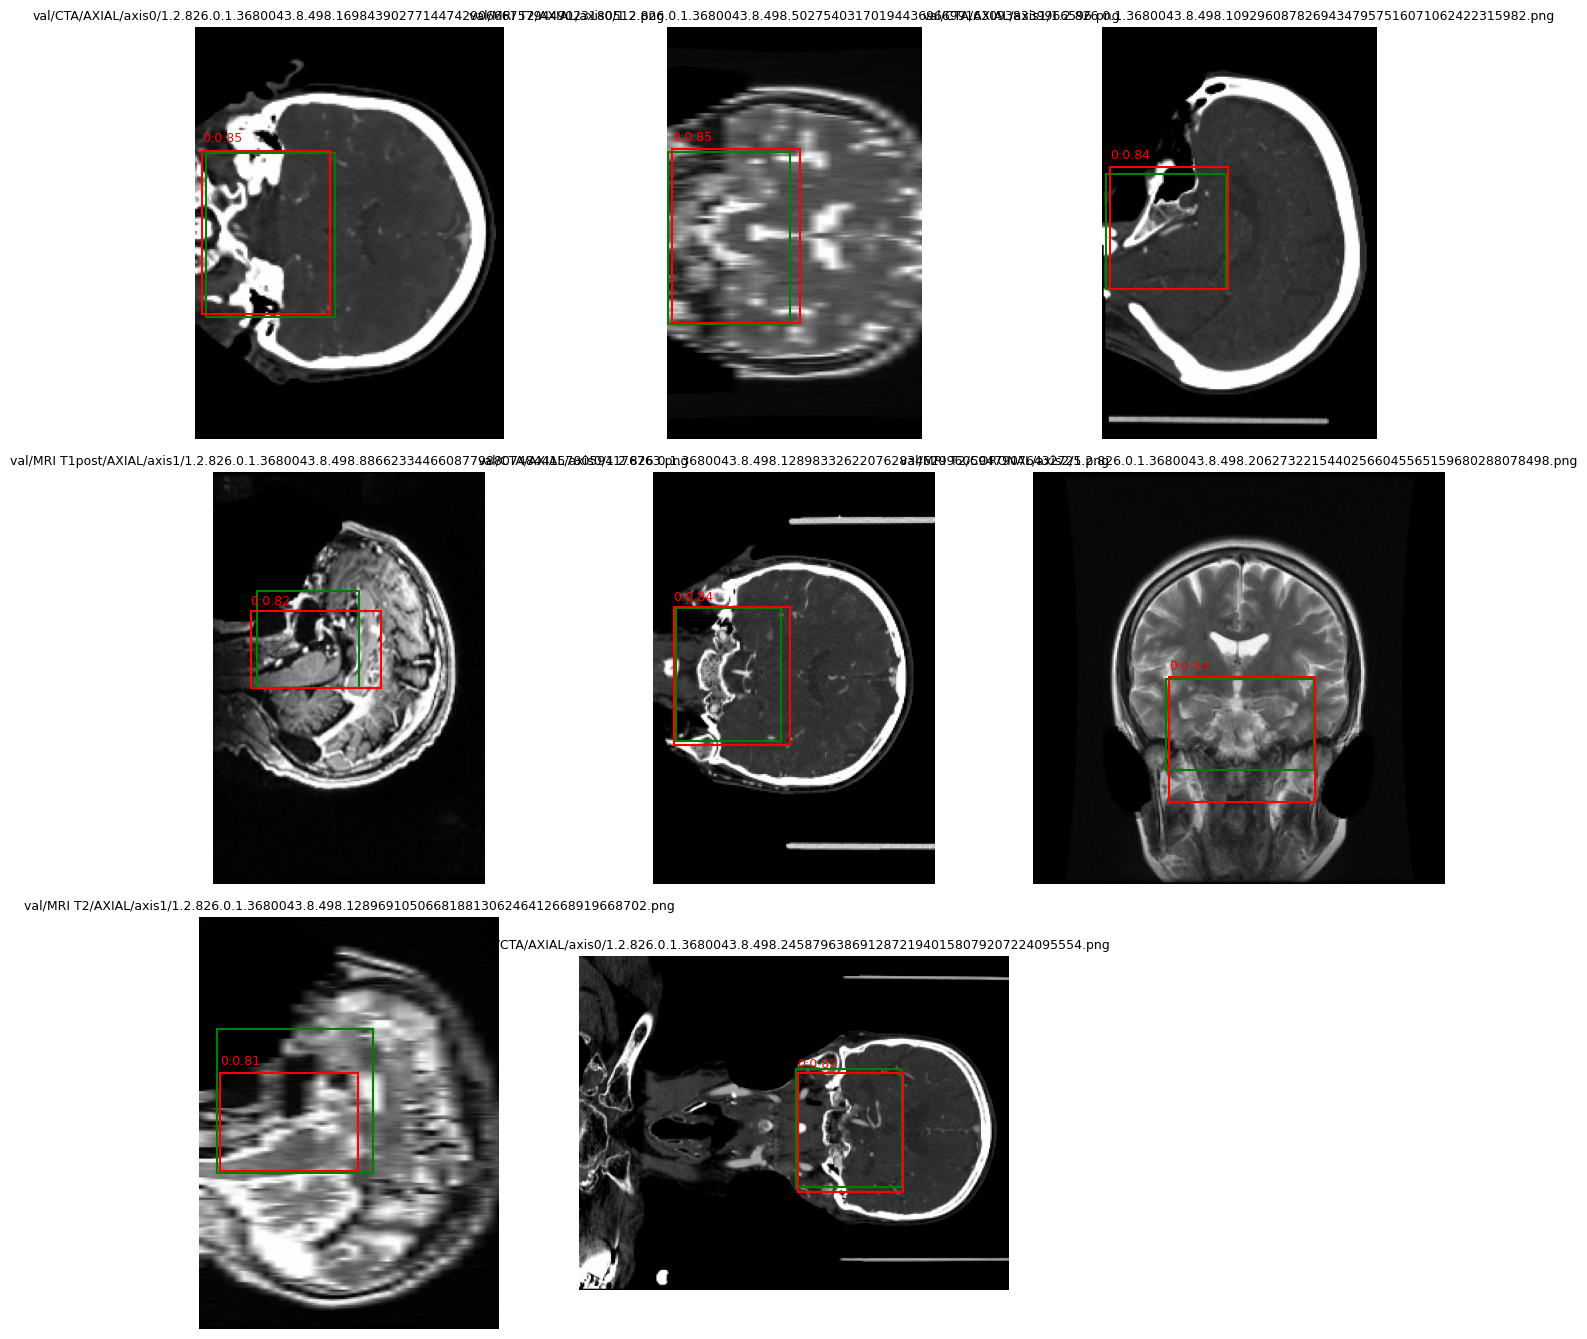

Saved TTA preview: /kaggle/working/yolo_cv_rot90/runs/fold1/predictions_grid.png

===== Fold 2/5 =====
[Split summary]  base: /kaggle/working/yolo_cv_rot90/fold2  (val_fold=2)
  train imgs:   294 | lbls:   294 | skipped:     0
  val   imgs:    58 | lbls:    58 | skipped:     0
YAML:     /kaggle/working/yolo_cv_rot90/fold2/dataset.yaml
Manifest: /kaggle/working/yolo_cv_rot90/fold2/manifest.csv
[augment] train images: 294 | angles=(90, 180, 270)
[augment] done.
Directory status:
- /kaggle/working/yolo_cv_rot90/fold2/images/train exists: True
- /kaggle/working/yolo_cv_rot90/fold2/images/val   exists: True
- /kaggle/working/yolo_cv_rot90/fold2/labels/train exists: True
- /kaggle/working/yolo_cv_rot90/fold2/labels/val   exists: True
Found dataset.yaml at /kaggle/working/yolo_cv_rot90/fold2/dataset.yaml
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, bo

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         58         58       0.93      0.983      0.965      0.616
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold2
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 593.4±255.3 MB/s, size: 16.5 KB)
val: Scanning /kaggle/working/yolo_cv_rot90/fold2/labels/val/CTA/AXIAL/axis0.cache... 58 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 58/58 92886.5it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 4.6it/s 0.9s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         58         58      0.962      0.983      0.981      0.627
Speed: 1.5ms preprocess, 7.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold2


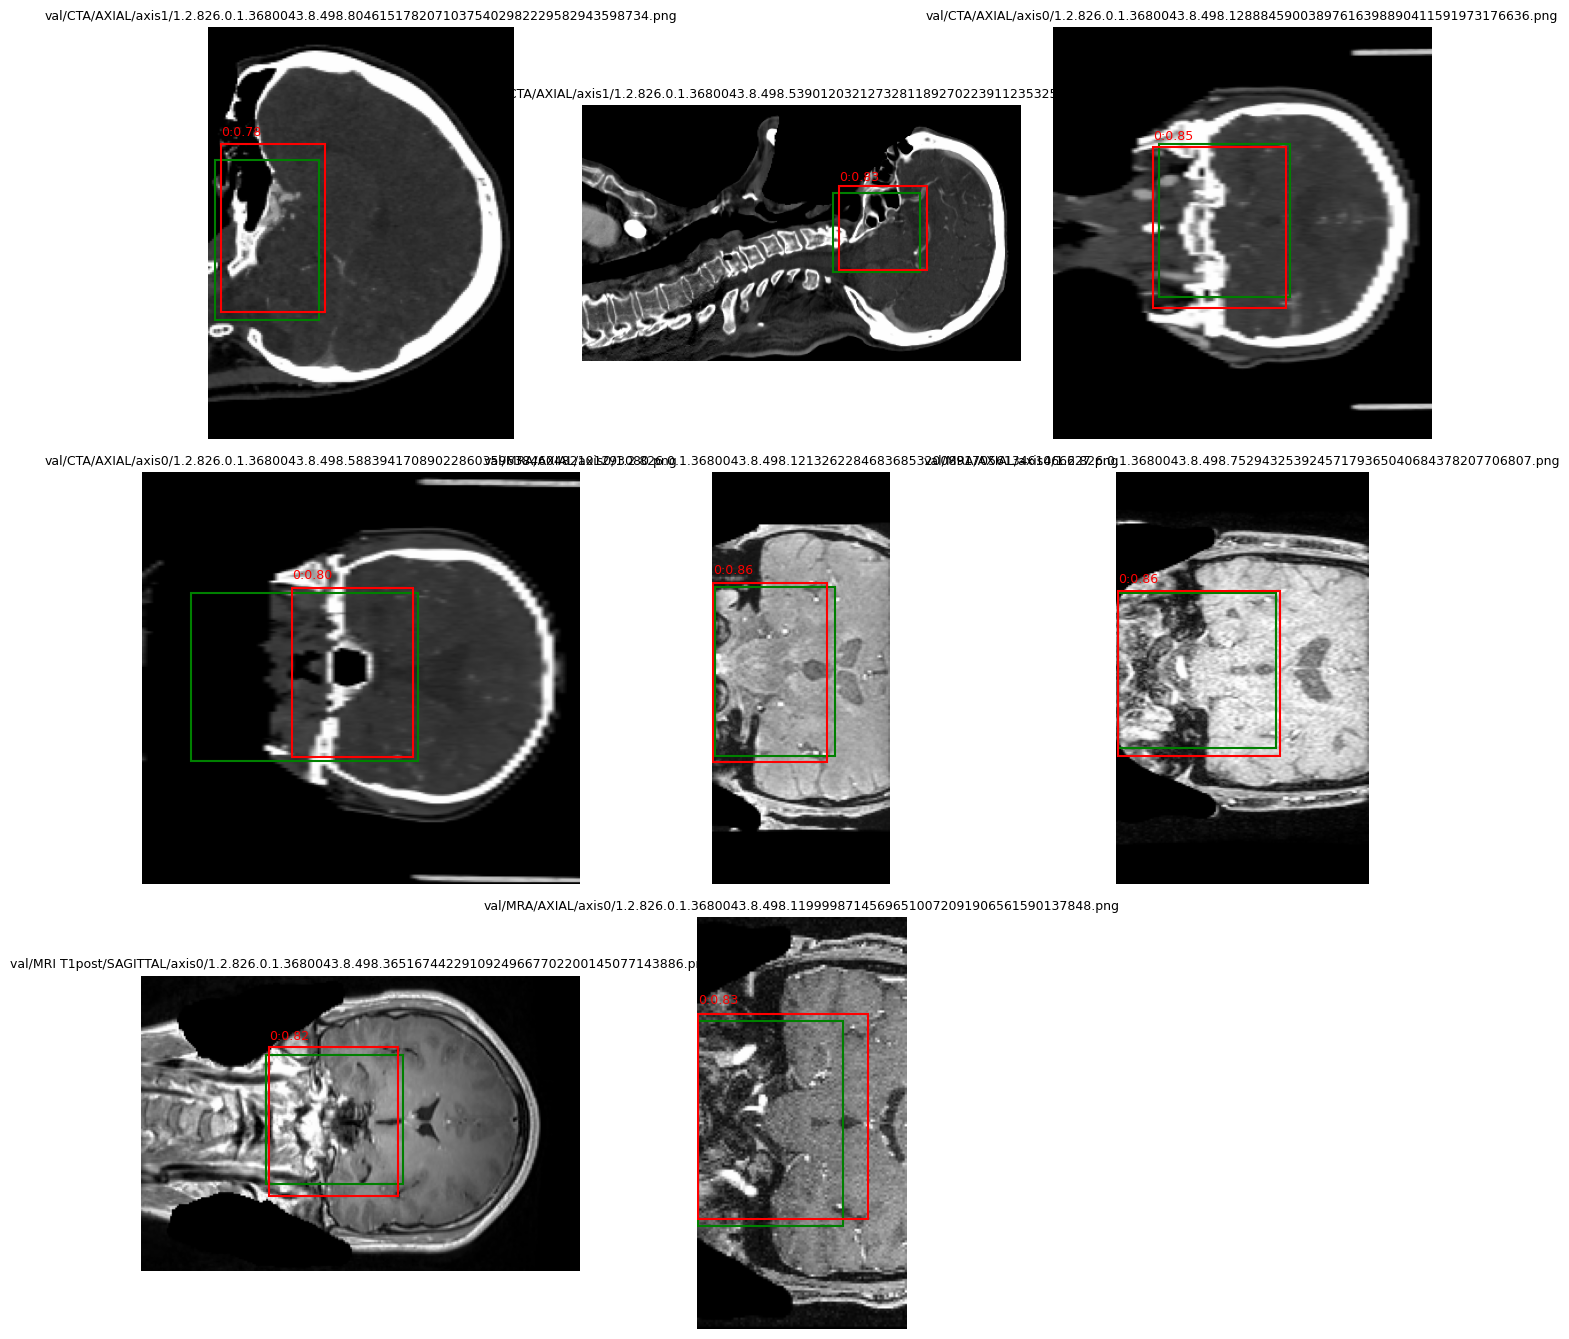

Saved TTA preview: /kaggle/working/yolo_cv_rot90/runs/fold2/predictions_grid.png

===== Fold 3/5 =====
[Split summary]  base: /kaggle/working/yolo_cv_rot90/fold3  (val_fold=3)
  train imgs:   290 | lbls:   290 | skipped:     0
  val   imgs:    62 | lbls:    62 | skipped:     0
YAML:     /kaggle/working/yolo_cv_rot90/fold3/dataset.yaml
Manifest: /kaggle/working/yolo_cv_rot90/fold3/manifest.csv
[augment] train images: 290 | angles=(90, 180, 270)
[augment] done.
Directory status:
- /kaggle/working/yolo_cv_rot90/fold3/images/train exists: True
- /kaggle/working/yolo_cv_rot90/fold3/images/val   exists: True
- /kaggle/working/yolo_cv_rot90/fold3/labels/train exists: True
- /kaggle/working/yolo_cv_rot90/fold3/labels/val   exists: True
Found dataset.yaml at /kaggle/working/yolo_cv_rot90/fold3/dataset.yaml
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, bo

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         62         62      0.984      0.981      0.984      0.607
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold3
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 555.8±94.3 MB/s, size: 14.6 KB)
val: Scanning /kaggle/working/yolo_cv_rot90/fold3/labels/val/CTA/AXIAL/axis0.cache... 62 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 62/62 103728.3it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 4/4 4.4it/s 0.9s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         62         62      0.984      0.981      0.984      0.621
Speed: 0.5ms preprocess, 7.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold3


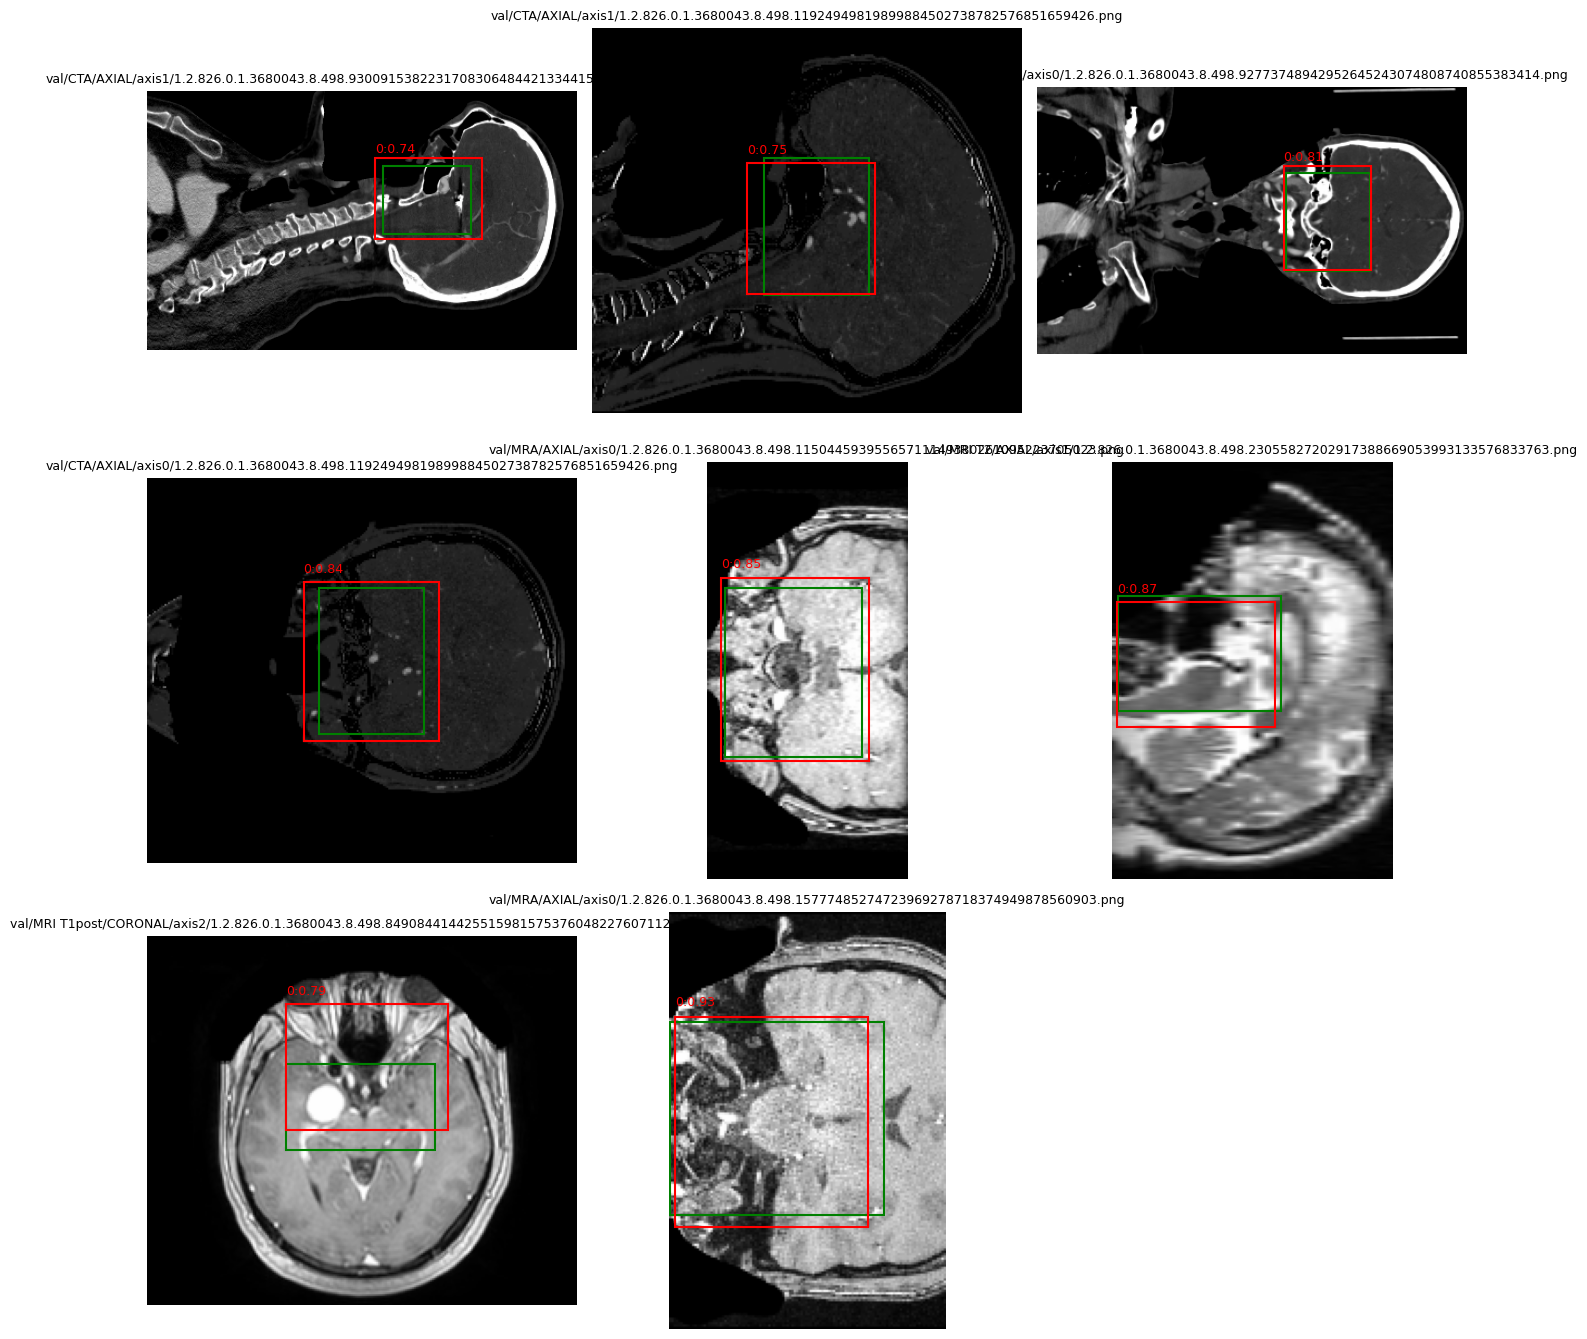

Saved TTA preview: /kaggle/working/yolo_cv_rot90/runs/fold3/predictions_grid.png

===== Fold 4/5 =====
[Split summary]  base: /kaggle/working/yolo_cv_rot90/fold4  (val_fold=4)
  train imgs:   274 | lbls:   274 | skipped:     0
  val   imgs:    78 | lbls:    78 | skipped:     0
YAML:     /kaggle/working/yolo_cv_rot90/fold4/dataset.yaml
Manifest: /kaggle/working/yolo_cv_rot90/fold4/manifest.csv
[augment] train images: 274 | angles=(90, 180, 270)
[augment] done.
Directory status:
- /kaggle/working/yolo_cv_rot90/fold4/images/train exists: True
- /kaggle/working/yolo_cv_rot90/fold4/images/val   exists: True
- /kaggle/working/yolo_cv_rot90/fold4/labels/train exists: True
- /kaggle/working/yolo_cv_rot90/fold4/labels/val   exists: True
Found dataset.yaml at /kaggle/working/yolo_cv_rot90/fold4/dataset.yaml
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, bo

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         78         78      0.961       0.96      0.964      0.553
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold4
Ultralytics 8.3.190 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 542.5±142.3 MB/s, size: 14.6 KB)
val: Scanning /kaggle/working/yolo_cv_rot90/fold4/labels/val/CTA/AXIAL/axis0.cache... 78 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 78/78 144058.0it/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 4.5it/s 1.1s


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all         78         78      0.974      0.959      0.973      0.552
Speed: 1.0ms preprocess, 6.3ms inference, 0.1ms loss, 2.8ms postprocess per image
Results saved to /kaggle/working/yolo_cv_rot90/runs/fold4


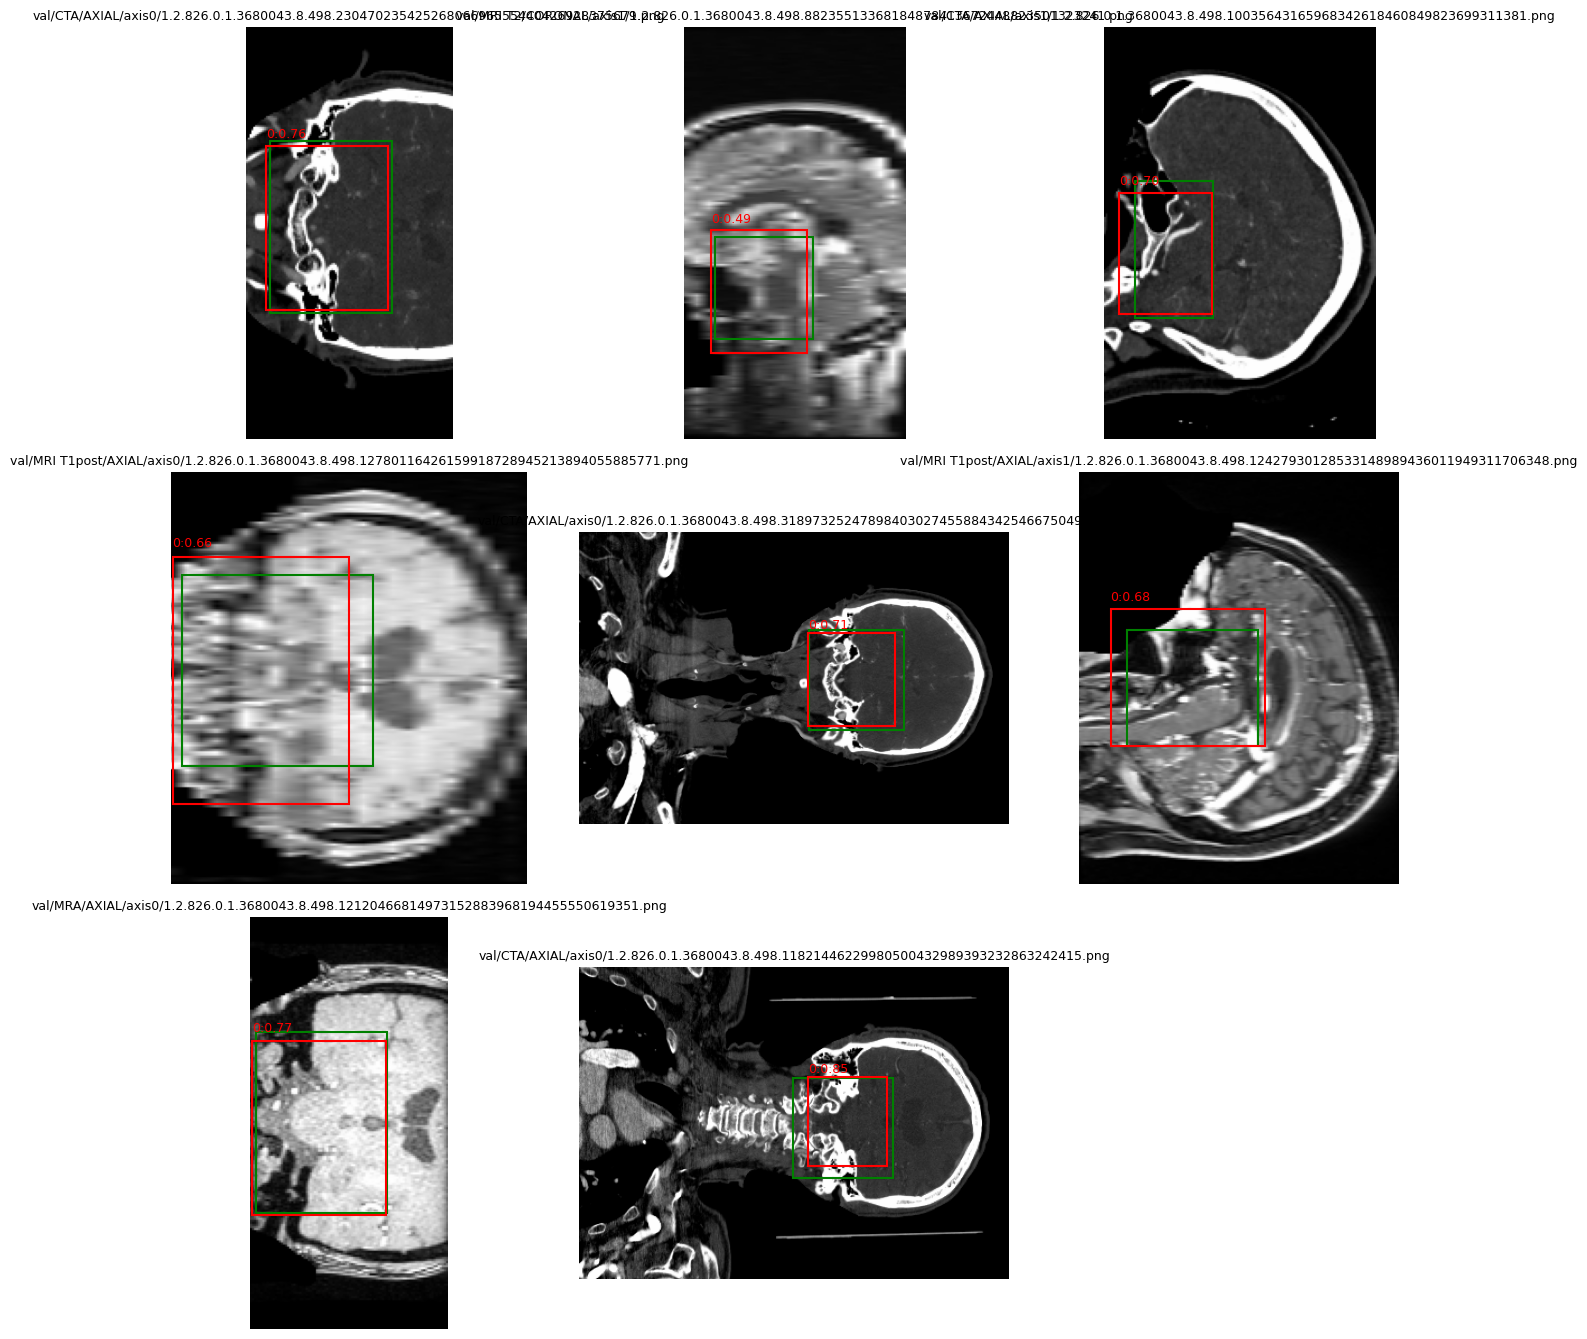

Saved TTA preview: /kaggle/working/yolo_cv_rot90/runs/fold4/predictions_grid.png

===== Cross-Validation Summary =====
                  mean       std  wavg_by_images  wavg_by_boxes
mAP50-95      0.586632  0.043202        0.582695       0.582695
mAP50         0.958090  0.040871        0.955555       0.955555
precision     0.957083  0.023633        0.955701       0.955701
recall        0.958193  0.035206        0.955702       0.955702
val/box_loss  1.477096  0.167222        1.486999       1.486999
val/cls_loss  0.629344  0.118749        0.638867       0.638867
val/dfl_loss  1.468568  0.120161        1.475848       1.475848

Saved CV raw per-fold metrics => /kaggle/working/yolo_cv_rot90/cv_summary/cv_folds_raw.csv
Saved CV summary            => /kaggle/working/yolo_cv_rot90/cv_summary/cv_summary.csv


fold                                   run_dir  \
0     0  /kaggle/working/yolo_cv_rot90/runs/fold0   
1     1  /kaggle/working/yolo_cv_rot90/runs/fold1   
2     2  /kaggle/working/yolo_cv_rot90/runs/fold2   
3     3  /kaggle/working/yolo_cv_rot90/runs/fold3   
4     4  /kaggle/working/yolo_cv_rot90/runs/fold4   

                           dataset_dir  val_images  val_boxes  mAP50-95  \
0  /kaggle/working/yolo_cv_rot90/fold0          78         78  0.529999   
1  /kaggle/working/yolo_cv_rot90/fold1          76         76  0.603261   
2  /kaggle/working/yolo_cv_rot90/fold2          58         58  0.626781   
3  /kaggle/working/yolo_cv_rot90/fold3          62         62  0.620981   
4  /kaggle/working/yolo_cv_rot90/fold4          78         78  0.552136   

      mAP50  precision    recall  val/box_loss  val/cls_loss  val/dfl_loss  \
0  0.886054   0.929043  0.897436       1.68734       0.82469       1.62512   
1  0.966494   0.936515  0.970545       1.29563       0.60419       1.35473   
2  0.980802   0.962066  0.982759       1.36955       0.54592       1.43226   
3  0.984418   0.983820  0.980745       1.41635       0.52727       1.36803   
4  0.972683   0.973971  0.959482       1.61661       0.64465       1.56270   

   metrics/mAP50-95(B)  metrics/mAP50(B)  metrics/precision(B)  \
0              0.52326           0.87235               0.93015   
1              0.59792           0.97079               0.94513   
2              0.60832           0.97401               0.94621   
3              0.60644           0.98457               0.98382   
4              0.54093           0.96802               0.97538   

   metrics/recall(B)  
0            0.87179  
1            0.97368  
2            0.96552  
3            0.98070  
4            0.96154

mean       std  wavg_by_images  wavg_by_boxes
fold                   2.000000  1.581139        1.960227       1.960227
mAP50                  0.958090  0.040871        0.955555       0.955555
mAP50-95               0.586632  0.043202        0.582695       0.582695
metrics/mAP50(B)       0.953948  0.046044        0.951321       0.951321
metrics/mAP50-95(B)    0.575374  0.040191        0.571962       0.571962
metrics/precision(B)   0.956138  0.022537        0.955506       0.955506
metrics/recall(B)      0.950646  0.044699        0.948304       0.948304
precision              0.957083  0.023633        0.955701       0.955701
recall                 0.958193  0.035206        0.955702       0.955702
val/box_loss           1.477096  0.167222        1.486999       1.486999
val/cls_loss           0.629344  0.118749        0.638867       0.638867
val/dfl_loss           1.468568  0.120161        1.475848       1.475848
val_boxes             70.400000  9.633276       71.454545      71.454545
val_images            70.400000  9.633276       71.454545      71.454545

In [11]:
# cv_result = run_5fold_training_with_cv(
#     df,
#     base_out_dir="/kaggle/working/yolo_cv",
#     pretrained_weights_path="yolov8n.pt",
#     epochs=30, batch_size=16, img_size=320,
#     folds=5, include_unlabeled=True, rect=True,
#     class_names={0: "aneurysm"},
# )
cv_result = run_5fold_training_with_rot90_cv(
    df,
    base_out_dir="/kaggle/working/yolo_cv_rot90",
    pretrained_weights_path="yolov8n.pt",  # 例: 任意のv8/v11など
    folds=5,
    angles=(90,180,270),       # 90°回転TTAではなく“学習データの増強”
    include_unlabeled=True,    # 空txtを作ってでも全件保存する場合
    class_names={0: "aneurysm"},
    epochs=30, batch_size=16, img_size=320,
    rect=True,
)

# 集計の DataFrame
display(cv_result["per_fold"])   # 各 fold の生メトリクス
display(cv_result["summary"])    # CV の mean / std / 重み付き平均